# **Chap3：卷积神经网络**

In [1]:
import tensorflow as tf
import numpy as np
import cv2
from matplotlib import pyplot as plt
from source.code import ch3
from source.code import utils

2023-07-09 17:59:42.564066: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-09 17:59:42.705680: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-09 17:59:42.738402: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-09 17:59:43.435629: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
# 如果你要在服务器上和别人共用GPU，可以设置你需要的显存资源
utils.gpu_limitation_config(memory=30)

## **3.4 正则化和迁移学习**

### **3.4.1 数据增强 / 图像增广**

**大型数据集是成功应用深度神经网络的先决条件**，**图像增广**（**Image Augmentation**）在对训练图像进行一系列的随机变化之后，生成相似但不同的训练样本，从而扩大了训练集的规模：
* 一方面，**图像增广技巧能极大丰富样本特征，提升模型的泛化能力**
  * 例如人脸识别，真实场景中采集到的人靓图像的角度，光照，视角差别很大，图像增广通过对训练数据的随机变换能模拟真实场景中的这种不稳定性
* **随机改变训练样本可以减少模型对某些属性的依赖，让模型真正抓住图像中的核心特征**，去除深度模型的**像素级记忆**（例如`ResNet`在`CIFAR-100`训练集上拟合到100%正确率），从而提高模型的泛化能力，因此这可以作为一种**正则化手段**
  * 对输入图像的随机变换也是一种在训练阶段引入随机性的方法，这是我们提到的另一种**随机化正则手段**

In [3]:
def apply_augmentation(image, aug, nrows : int=2, ncols : int=4):
    """
    对图像`image`进行`aug`变换，用于演示
    """
    images = [aug(image,training=True) for _ in range(ncols*nrows)]
    fig,ax = plt.subplots(nrows,ncols,figsize=(0.5*ncols,0.5*nrows))
    ax = ax.flatten()
    for i,img in enumerate(images):
        ax[i].imshow(img)
    plt.tight_layout()

注意：**图像增广只在训练时发挥作用**，因此调用`__call__()`方法时需要设定`training = True`参数

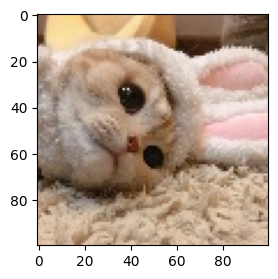

In [4]:
image = cv2.imread("../source/Chap3/cat.jpg")
# 更换通道顺序，cv2 的通道顺序是 Blue, Green 和 Red
B,G,R = cv2.split(image)
image = cv2.merge([R,G,B])
image = image.astype("float") / 255
fig = plt.figure(figsize=(3,3))
plt.imshow(image)

**(1) 随即翻转**

可以指定对图像进行`水平`，`垂直`，`水平或垂直`的随机翻转

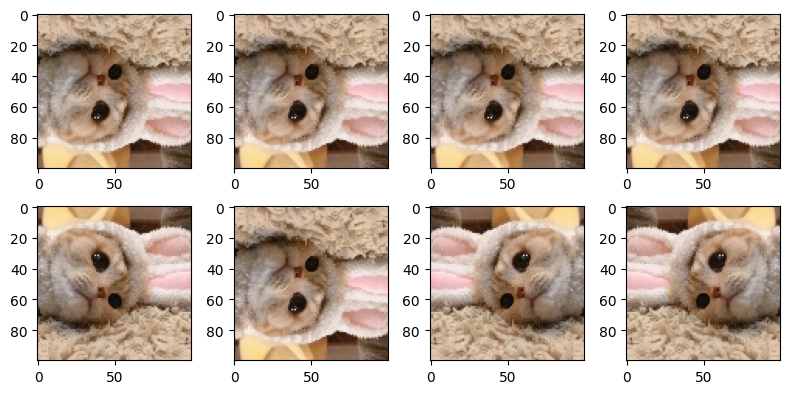

In [7]:
# 随机翻转
aug = tf.keras.layers.RandomFlip()
utils.apply_augmentation(image=image,aug=aug)

**(2) 随机裁剪**

可以设定一个窗口大小，例如高度和宽度都为70，然后随即在画面中进行裁剪

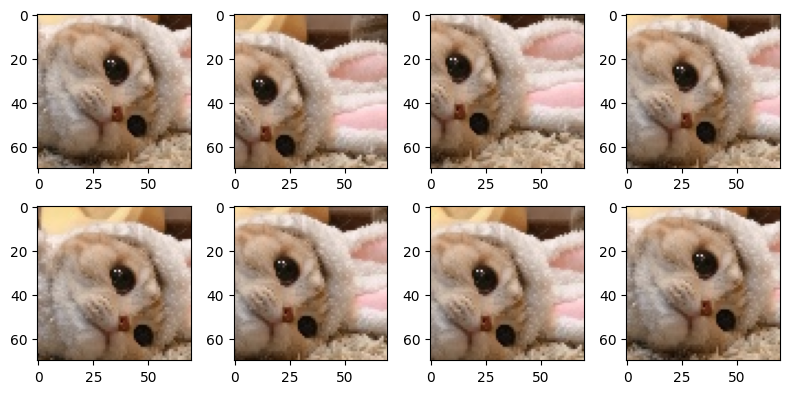

In [8]:
# 随机裁剪
aug = tf.keras.layers.RandomCrop(width=70,height=70)
utils.apply_augmentation(image=image,aug=aug)

**(3) 随机旋转**

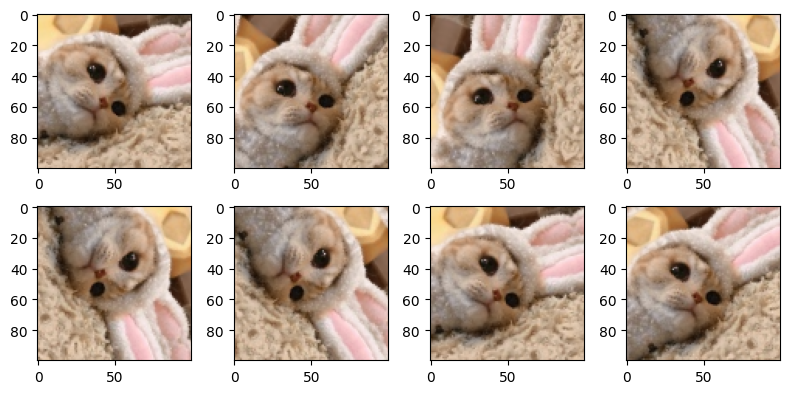

In [9]:
# 随机旋转
aug = tf.keras.layers.RandomRotation(factor=0.2)
utils.apply_augmentation(image=image,aug=aug)

**(4) 随机拉伸图像**

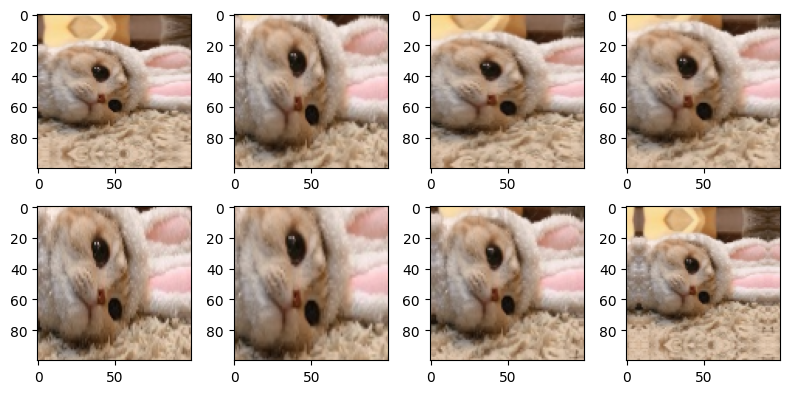

In [10]:
# 随机拉伸图像
aug = tf.keras.layers.RandomZoom(height_factor=0.4,width_factor=0.2)
utils.apply_augmentation(image=image,aug=aug)

**(5) 随机调整亮度**

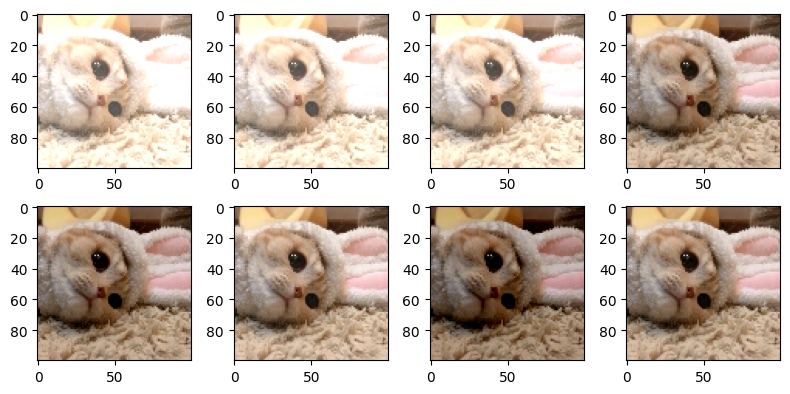

In [11]:
# 随机拉伸图像
aug = tf.keras.layers.RandomBrightness(factor=0.3,value_range=[0,1])
utils.apply_augmentation(image=image,aug=aug)

**(6) 随机平移**

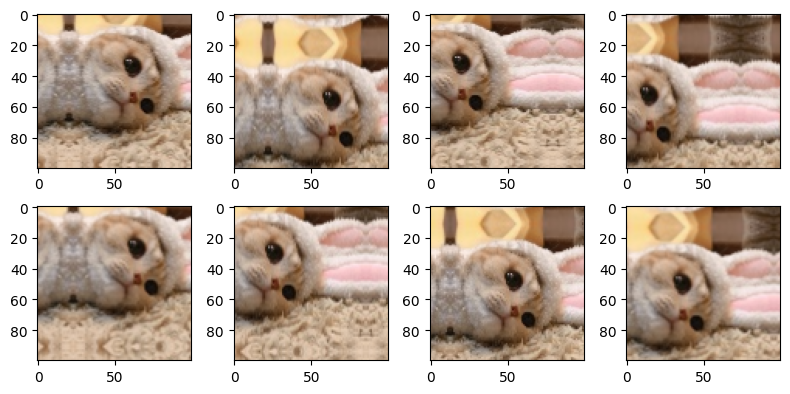

In [12]:
# 随机拉伸图像
aug = tf.keras.layers.RandomTranslation(height_factor=(-0.2,0.2),width_factor=(-0.3,0.3))
utils.apply_augmentation(image=image,aug=aug)

深度学习框架还提供了更多的图像增广变换，例如随机改变色调，对比度等，这些功能**在需要的时候可以查询文档使用**

我们可以**将上述这些多种变换组合，共同实现图像增广**

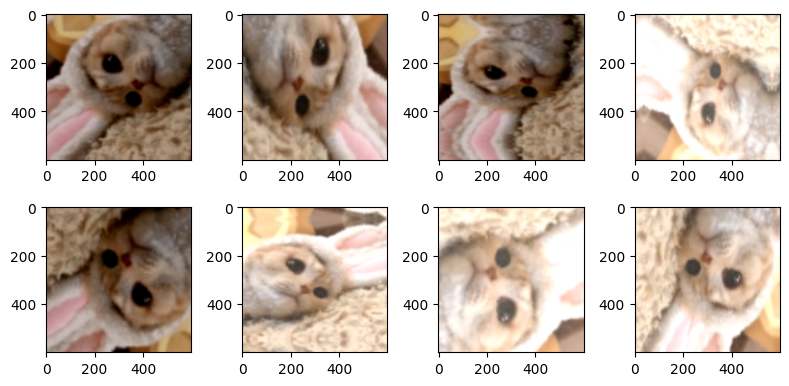

In [13]:
aug = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip(), # 随机翻转
    tf.keras.layers.RandomRotation(factor=0.2), # 随机旋转
    tf.keras.layers.RandomZoom(height_factor=0.4,width_factor=0.2), # 随机拉伸
    tf.keras.layers.RandomBrightness(factor=0.3,value_range=[0,1]), # 随机改变亮度
    tf.keras.layers.RandomCrop(width=600,height=600) # 随机裁剪
])
utils.apply_augmentation(image=image,aug=aug)

上面演示的图像增广被定义为模型计算层（Layer）的一部分，`keras`还提供了另一种图像增广的接口，在`tf.keras.preprocessing.image.ImageDataGenerator()`中，它可以视为**工作在数据预处理的部分**

In [14]:
aug = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=30,
    # 随机平移
    width_shift_range=0.1,
    height_shift_range=0.1,
    # 随机翻转
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0, # 还可以用于切分训练集和验证集
    # 还可以指定预处理函数
    # 例如更换色调
    preprocessing_function=lambda x : tf.image.random_hue(x,max_delta=0.5) 
)

In [16]:
image_batch = tf.expand_dims(image,axis=0) # 添加批量维度
# 通过 flow 方法生成一个迭代器
for x_batch in aug.flow(image_batch,batch_size=1):
    break

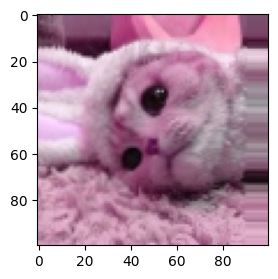

In [17]:
fig = plt.figure(figsize=(3,3))
plt.imshow(x_batch[0])

由于`ImageDataGenerator`属于数据预处理的模块，如果要通过`ImageDataGenerator`实现数据增强，需要稍微调整我们的模型训练函数，通过`flow`方法**作用到每一个批量的训练数据上**，而如果是使用前面的按`tf.keras.layers`层定义的图像增广，则可以包装到模型内部，就不需要更改模型的训练函数

**有关图像增广具体使用的部分，留做习题**

### **3.4.2 微调和迁移学习**

从特征图的角度出发，我们应该将神经网络分为两个部分：
* **除去最后全连接层的部分**，都应该视为一个**特征提取器**，它们的任务是**将原始输入经过复杂的非线性变换，加工得到对分类器真正有效的高层特征信号**
* **最后的全连接层**是真正分类任务的分类器，他将特征提取器加工得到的特征通过一个线性模型和`Softmax()`变换得到概率分布

深度学习的最理想情况就是得到一个**通用的特征提取器**，即我们希望前面这么多**复杂的网络结构所加工得到的特征图不仅对训练数据集有效，而应该对任何其他相似的数据也有特征加工能力**，实践中人们发现，一个复杂庞大的模型，其**训练时见过的数据越多，种类越多样，最后得到的特征提取器的特征加工能力和泛化性就越强**

基于此，人们提出了一种**深度学习模型的迁移学习框架**，称为**微调**（**Fine Tuning**）

**迁移学习的基本想法**是：
* 我们有一个目标任务 $T$（例如猫狗分类），但 $T$ 相关的数据较少，因此想得到较好的模型比较困难
* 但我们有很多相关的，或相似的任务 $S$（例如 ImageNet-1000 分类），它们可以作为辅助数据，为目标问题 $T$ 进行补充，辅助数据集的特点是数据充分
* 迁移学习希望**让模型将** $S$ **中有用的知识迁移到** $T$ **中**，以**提升模型在** $T$ **上的表现**
* 但需要注意，不能直接将 $S$ 上训练得到的模型用于 $T$，**因为两个问题存在分布差异，有时候甚至两个任务是不共通的**

深度学习认为，在 $S$ 这种大规模数据集上训练得到的深度模型，**其特征提取能力很优秀，有助于提升模型在其他任务上的表现**，具体的，**FineTuning做迁移学习的思想**是：
* 实例化一个基础模型，并加载其**在大规模数据集上训练**得到的参数（权重和偏置），这一步通常称为**预训练**（**Pre-Training**）
  * 通常来讲，人们在一些重要的数据集上都训练过经典模型，这些参数可以下载得到，因此可以直接加载参数，预训练的过程就省去了
  * 但如果是自己设计的模型，或者是自己准备的数据集，这些参数就需要通过自己预训练得到了
  * 总之，**预训练可以理解为，让模型在较大规模的数据集上先训练，以获得优秀的特征提取能力**
* 通过设置`trainable = False`冻结基础模型中的所有层
* 使用基础模型中一个（或多个）层的输出，**根据我们关心的具体任务，创建一个新模型，得到模型输出**（通常称为**下游任务**，**下游网络**）
* 在我们目标的数据集 $T$ 上**微调训练新模型**，而微调一般分为两个阶段
  * 第一阶段，我们会**保持冻结所有特征提取器**，利用特征提取器加工得到的特征，仅更新新增加的模型结构部分的参数（即更新下游模型）
  * 第二阶段，**待下游模型接近收敛，解冻特征提取器**，用很小的学习率更新整个模型，让特征提取器更适合于目标任务 $T$

接下来，我们通过演示**猫狗分类**实现FineTuning的流程

**(1) 第一步，从`tensorflow_datasets`加载数据集**

In [52]:
import tensorflow_datasets as tfds

train_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # 50%作为训练集，10%作为测试集
    split=["train[:50%]", "train[50%:60%]"],
    as_supervised=True,  # 包含标签
)

In [53]:
print("训练集样本量：",tf.data.experimental.cardinality(train_ds).numpy())
print("测试集样本量：",tf.data.experimental.cardinality(test_ds).numpy())

训练集样本量： 11631
测试集样本量： 2326


绘制部分样本观察，以便于标准化数据

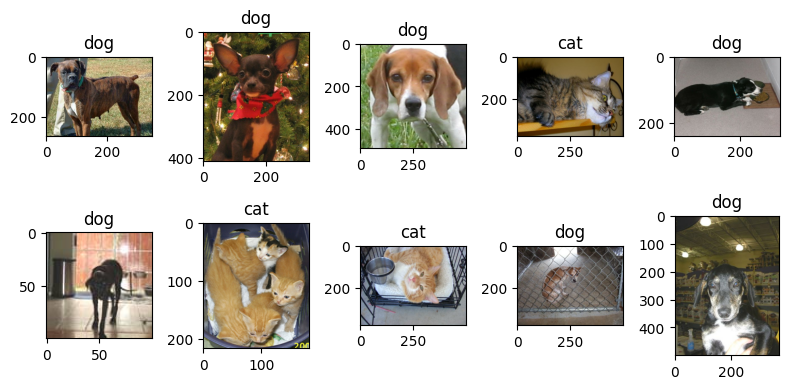

In [56]:
fig, ax = plt.subplots(2, 5,figsize=(8, 4))
ax = ax.flatten()
for i, (image, label) in enumerate(train_ds.take(10)):
    ax[i].imshow(image)
    label = "cat" if label == 0 else "dog"
    ax[i].set_title(label)
plt.tight_layout()

**(2) 标准化图像输入**

观察得到，我们需要**进行的标准化**包括：
* 将**图像大小统一**，例如统一到 $150\times 150$ 像素
* 将**图像像素规范化**到区间 $[-1,1]$ 之间的浮点数
  * 如果**需要进行图像增广的操作，那么这一步可以在后面模型定义中实现**

此外，`Tensorflow`还可以对数据**进行批处理并使用缓存和预提取来优化加载速度**

In [100]:
batch_size = 32
size = (150, 150)
# 训练集
train_ds = train_ds.map(lambda x,y : (tf.image.resize(x, size), y))
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
# 测试集
test_ds = test_ds.map(lambda x,y : (tf.image.resize(x, size), y))
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

**(3) 构建模型**

接下来，创建一个基础模型，并导入在`ImageNet`上预训练好的参数

In [71]:
base_model = tf.keras.applications.VGG16(
    weights="imagenet", # 加载 ImageNet 预训练参数
    input_shape=(150, 150, 3), # 设定输入图像大小
    include_top=False # 不包含顶层，即最后的全连接层
)
# 冻结模型
base_model.trainable = False

In [72]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

可以看到，这个`VGG16`网络的**所有参数均被冻结，它们不会参与训练**

接下来，我们定义下游网络，即最后的全连接层，搭建猫狗二分类模型，下面是一种新的`Tensorflow`模型的定义方式

In [78]:
# 定义模型输入
inputs = tf.keras.layers.Input(shape=(150,150,3))

# 创建数据增强层
data_aug = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip("horizontal"), # 随机翻转
    tf.keras.layers.RandomRotation(0.15) # 随机旋转
])
x = data_aug(inputs) # 应用图像增广

# 将输入元素标准化到 [-1,1]
scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# 创建顶层模型，即最后的分类器
classifier = tf.keras.models.Sequential([
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1)
])

# 定义计算过程
# 特征提取器不参与训练
x = base_model(x,training=False)
outputs = tf.nn.sigmoid(classifier(x,training=True)) # 转换为概率

# 包装模型
model = tf.keras.Model(inputs,outputs)

In [79]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_16 (Sequential)  (None, 150, 150, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 sequential_17 (Sequential)  (None, 1)                 513       
                                                                 
 tf.math.sigmoid_3 (TFOpLamb  (None, 1)                0         
 da)                                                             
                                                           

**(4) 模型训练**

第一步，我们先训练顶层，即最后的全连接层网络

In [80]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

In [81]:
epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=test_ds)

Epoch 1/20


364/364 [==============================] - 31s 70ms/step - loss: 0.4921 - binary_accuracy: 0.7818 - val_loss: 0.3023 - val_binary_accuracy: 0.8895
Epoch 2/20
364/364 [==============================] - 24s 65ms/step - loss: 0.3645 - binary_accuracy: 0.8525 - val_loss: 0.2471 - val_binary_accuracy: 0.9067
Epoch 3/20
364/364 [==============================] - 24s 65ms/step - loss: 0.3301 - binary_accuracy: 0.8614 - val_loss: 0.2307 - val_binary_accuracy: 0.9071
Epoch 4/20
364/364 [==============================] - 23s 64ms/step - loss: 0.3136 - binary_accuracy: 0.8679 - val_loss: 0.2203 - val_binary_accuracy: 0.9136
Epoch 5/20
364/364 [==============================] - 23s 64ms/step - loss: 0.3085 - binary_accuracy: 0.8661 - val_loss: 0.2164 - val_binary_accuracy: 0.9050
Epoch 6/20
364/364 [==============================] - 23s 64ms/step - loss: 0.2994 - binary_accuracy: 0.8687 - val_loss: 0.2030 - val_binary_accuracy: 0.9183
Epoch 7/20
364/364 [==============================] - 23s 64ms/

可以观察到两点：
* 此时，**模型在测试集上的准确率可以达到 92%，并且我们没有观察到过拟合**
* 模型在一开始的**第一次迭代，正确率就可以接近 90%**，说明**特征提取器中冻结的参数，确实能有效提取特征图**提供给分类器

第二步，我们**解冻特征提取器，重新编译模型**，然后用很小的学习率，更新模型的所有参数

In [82]:
# 解冻特征提取器
base_model.trainable = True
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_16 (Sequential)  (None, 150, 150, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 sequential_17 (Sequential)  (None, 1)                 513       
                                                                 
 tf.math.sigmoid_3 (TFOpLamb  (None, 1)                0         
 da)                                                             
                                                           

In [83]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # 设置很小的学习率
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

In [84]:
epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=test_ds)

Epoch 1/10


364/364 [==============================] - 47s 119ms/step - loss: 0.1751 - binary_accuracy: 0.9276 - val_loss: 0.0994 - val_binary_accuracy: 0.9635
Epoch 2/10
364/364 [==============================] - 41s 113ms/step - loss: 0.1025 - binary_accuracy: 0.9586 - val_loss: 0.0965 - val_binary_accuracy: 0.9652
Epoch 3/10
364/364 [==============================] - 42s 116ms/step - loss: 0.0830 - binary_accuracy: 0.9666 - val_loss: 0.0824 - val_binary_accuracy: 0.9695
Epoch 4/10
364/364 [==============================] - 42s 116ms/step - loss: 0.0738 - binary_accuracy: 0.9694 - val_loss: 0.0772 - val_binary_accuracy: 0.9721
Epoch 5/10
364/364 [==============================] - 43s 119ms/step - loss: 0.0551 - binary_accuracy: 0.9796 - val_loss: 0.0776 - val_binary_accuracy: 0.9733
Epoch 6/10
364/364 [==============================] - 44s 120ms/step - loss: 0.0429 - binary_accuracy: 0.9833 - val_loss: 0.0884 - val_binary_accuracy: 0.9768
Epoch 7/10
364/364 [==============================] - 45s

经过第二阶段的调整后，**模型在测试集上的准确率可以达到 98%**，FineTuning 取得了出色的改进
* 此时需要小心，**由于解冻了所有参数，模型的拟合能力变强了，可能会在第二阶段训练时出现过拟合**，因此各种**正则化**手段（例如图像增广）是必要的

作为对比，我们创建一个相同的`VGG16`模型，但随机初始化它的参数，不使用迁移学习微调，仅在猫狗分类数据集上训练，查看模型性能

In [105]:
base_model = tf.keras.applications.VGG16(
    weights=None, # 随机初始化参数
    input_shape=(150, 150, 3), # 设定输入图像大小
    include_top=False # 不包含顶层，即最后的全连接层
)

# 定义模型输入
inputs = tf.keras.layers.Input(shape=(150,150,3))

# 创建数据增强层
data_aug = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip("horizontal"), # 随机翻转
    tf.keras.layers.RandomRotation(0.15) # 随机旋转
])
x = data_aug(inputs) # 应用图像增广

# 将输入元素标准化到 [-1,1]
scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# 创建顶层模型，即最后的分类器
classifier = tf.keras.models.Sequential([
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1)
])

# 定义计算过程
# 特征提取器不参与训练
x = base_model(x,training=False)
outputs = tf.nn.sigmoid(classifier(x,training=True)) # 转换为概率

# 包装模型
model = tf.keras.Model(inputs,outputs)

In [106]:
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_28 (Sequential)  (None, 150, 150, 3)       0         
                                                                 
 rescaling_13 (Rescaling)    (None, 150, 150, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 sequential_29 (Sequential)  (None, 1)                 513       
                                                                 
 tf.math.sigmoid_9 (TFOpLamb  (None, 1)                0         
 da)                                                             
                                                          

In [107]:
# 编译模型，进行训练
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

In [108]:
epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=test_ds)

Epoch 1/10


364/364 [==============================] - 44s 120ms/step - loss: 0.6932 - binary_accuracy: 0.5031 - val_loss: 0.6909 - val_binary_accuracy: 0.5490
Epoch 2/10
364/364 [==============================] - 45s 122ms/step - loss: 0.6915 - binary_accuracy: 0.5239 - val_loss: 0.6919 - val_binary_accuracy: 0.5254
Epoch 3/10
364/364 [==============================] - 45s 123ms/step - loss: 0.6880 - binary_accuracy: 0.5448 - val_loss: 0.6805 - val_binary_accuracy: 0.5800
Epoch 4/10
364/364 [==============================] - 45s 123ms/step - loss: 0.6797 - binary_accuracy: 0.5682 - val_loss: 0.6718 - val_binary_accuracy: 0.6019
Epoch 5/10
364/364 [==============================] - 46s 126ms/step - loss: 0.6682 - binary_accuracy: 0.5936 - val_loss: 0.6591 - val_binary_accuracy: 0.6118
Epoch 6/10
364/364 [==============================] - 45s 125ms/step - loss: 0.6581 - binary_accuracy: 0.6115 - val_loss: 0.6408 - val_binary_accuracy: 0.6397
Epoch 7/10
364/364 [==============================] - 45s

可以看到，从头训练一个深度学习模型，其性能、稳定性和收敛速度都远不如迁移学习微调

----

### **练习**

1. 该练习帮助你**巩固深度学习模型的设计和训练技巧**
   1. 运用所有学习到的知识，搭建一个卷积神经网络，训练一个 `CIFAR-100` 数据集分类器
   2. 网络可以自己设计，也可以选择已有的架构，例如 `VGGNet`，`ResNet` 等，或者在已有的架构上改进模型
   3. **注意我们提及到的所有深度学习模型训练技巧**，例如Dropout，BatchNorm，图像增广
      * 如果时间允许，你甚至可以尝试每次只引入一种技巧，观察每种技巧的引入对模型带来的影响，时刻关注模型的训练状态，这个调整的过程会非常耗费时间和精力，但有助于你更深入了解深度学习
   4. **你能让模型在测试集上的准确率达到 90% 以上吗？**

2. 该练习帮助你**理解深度学习模型的特征图概念**
   1. 选择一个你喜欢的**传统的机器学习算法**（`Lasso`，`决策树`等），在 `CIFAR-100` 上训练分类器，报告它在训练集和测试集上的准确率
      * 对于绝大部分机器学习算法，你都需要先将图像特征输入**拉直为向量**
   2. 使用迁移学习微调的方法，从 `tf.keras.applications` 中选择你喜欢的模型架构，用 `ImageNet` 预训练参数做初始化，在 `CIFAR-100` 上微调模型，**使得模型在测试集的正确率达到 90% 以上**
   3. 利用 **2** 训练得到的模型做预测，**将深度学习模型特征提取器的输出（即最后全连接层的输入）作为每个样本的特征**，利用这些特征重新训练 **1** 中你选择的机器学习模型，报告此时训练集和测试集上的准确率

3. 下面是一些开放式的问题，没有标准答案
   1. 尝试理解和解释图像增广为什么能极大缓解过拟合，它是如果做到**去除模型的像素化记忆的**
   2. **BatchNorm为什么通常放在激活函数前？**，它放在激活函数后可以吗？
      1. 如果放在激活函数后，尝试从直觉解释这样做的合理性
      2. 实践中，有没有简单的方法决定 BatchNorm 放前还是放后？
   3. 使用图像增广对输入进行随机变换时，在变换的选择上，你觉得需要注意些什么？

----